# HW02: Multi-label classification

## Kaggle Plant Seedlings Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/plant-seedlings-classification/'
PATH_train = os.path.join(PATH, 'train');
PATH_valid = os.path.join(PATH, 'valid');

In [4]:
# Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [5]:
ls {PATH}

models/  sample_submission.csv  test/  tmp/  train/  valid/


## Multi-label models for Plant Seedling dataset

In [4]:
f_model = resnet50

### Create validation data (only do this once)

In [21]:
# Put all VALIDATION data back to TRAIN folder

classes = os.listdir(PATH_valid)
for i in classes:
    src_path = os.path.join(PATH_valid, i)
    dst_path = os.path.join(PATH_train, i)
    
    all_img = os.listdir(src_path)  
    for j in all_img:
        shutil.move(os.path.join(src_path,j), os.path.join(dst_path,j))

In [22]:
# Randomly select 20% of TRAIN data as VALIDATION data
classes = os.listdir(PATH_train)

for i in classes:
    src_path = os.path.join(PATH_train, i)
    dst_path = os.path.join(PATH_valid, i)
    
    all_img = os.listdir(src_path)
    sample_img = np.random.choice(all_img, size=len(all_img)//5, replace=False)
    if not os.path.isdir(dst_path):
        os.mkdir(dst_path)
    
    for j in sample_img:
        shutil.move(os.path.join(src_path,j), os.path.join(dst_path,j))

In [5]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    data = ImageClassifierData.from_paths(PATH, trn_name='train', val_name='valid', test_name='test', tfms=tfms)
    return data if sz>=256 else data.resize(256, 'tmp')

In [6]:
data = get_data(256)

In [7]:
# list(zip(data.classes, y[0]))
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

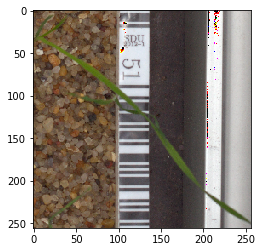

In [8]:
x,y = next(iter(data.val_dl))
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [11]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([1621.,  473.,  650.,  442.,  252.,  120.,   90.,   52.,   40.,   31.]),
 array([  49. ,  193.1,  337.2,  481.3,  625.4,  769.5,  913.6, 1057.7, 1201.8, 1345.9, 1490. ]),
 <a list of 10 Patch objects>)

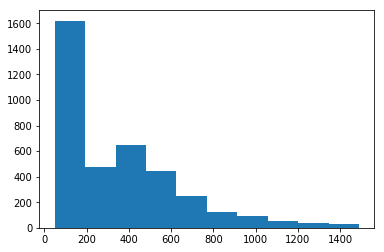

In [12]:
plt.hist(row_sz[row_sz<1500])

## Train Initial Model

In [14]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.160351   0.626676   0.804636  
    1      0.699219   0.479263   0.848652                  
    2      0.507306   0.421287   0.860907                  



[0.42128655, 0.8609068632125855]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 51/60 [00:01<00:00, 50.92it/s, loss=1.93] 


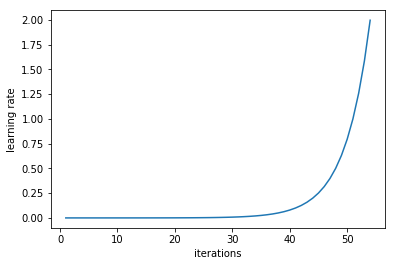

In [36]:
lrf = learn.lr_find()
learn.sched.plot_lr()

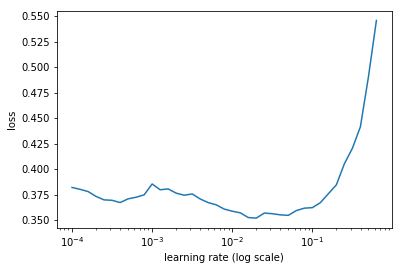

In [37]:
learn.sched.plot()

## Train Model Resnet50 256
comment: good initial results

In [13]:
data = get_data(256)
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.fit(0.01, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.278893   0.822467   0.742892  
    1      0.840154   0.541587   0.830699                  
    2      0.610067   0.516701   0.838766                  
    3      0.514621   0.443425   0.851532                  
    4      0.431553   0.437984   0.849449                  
    5      0.355901   0.392375   0.864808                  
    6      0.319245   0.387582   0.86924                   
    7      0.32892    0.387605   0.868199                  
    8      0.298714   0.36762    0.874449                  
    9      0.258795   0.368213   0.872365                  
    10     0.218774   0.344936   0.880433                  
    11     0.190362   0.331875   0.8846                    
    12     0.170378   0.338353   0.884069                  
    13     0.15834    0.339965   0.885641                  
    14     0.151707   0.338642   0.8846                    
    15     0.165447   0.354755   0.883292                

[0.33311933, 0.895016340414683]

In [14]:
learn.save('256_lastlayer')

In [15]:
learn.precompute = False
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.571043   0.311046   0.892667  
    1      0.335318   0.220355   0.920282                  
    2      0.223085   0.202924   0.933313                  
    3      0.194502   0.165255   0.937745                  
    4      0.162929   0.16494    0.933313                  
    5      0.136394   0.149387   0.94373                   
    6      0.115881   0.148307   0.942688                  



[0.14830738, 0.9426879088083903]

In [16]:
learn.save('256_all')

## Train Model Resnet50 512
Comment: it seems like the model is overfitting

In [85]:
data = get_data(512)
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.fit(0.01, 5, cycle_len=1, cycle_mult=2)


100%|██████████| 13/13 [00:37<00:00,  2.86s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.330717   0.884462   0.72598   
    1      0.882914   0.546036   0.836152                  
    2      0.62289    0.496011   0.856985                  
    3      0.537924   0.423841   0.869751                  
    4      0.430605   0.386256   0.877042                  
    5      0.357903   0.359926   0.890319                  
    6      0.309338   0.356581   0.888501                  
    7      0.321202   0.365361   0.885376                  
    8      0.291902   0.355257   0.889542                  
    9      0.250838   0.341102   0.890074                  
    10     0.213819   0.33097    0.891891                  
    11     0.176499   0.320615   0.895792                  
    12     0.16882    0.317834   0.901266                  
    13     0.153419   0.312074   0.898141                  
    14     0.155458   0.31561    0.899183                  
    15     0.164976   0.3377     0.893709                

[0.30755946, 0.9054330070813497]

In [88]:
learn.save('512_lastlayer')

In [ ]:
learn.precompute = False
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('512_all')

## Train Model Resnext 256
comment: not enough gpu memory when unfreezing earlier layers

In [13]:
f_model = resnext50
data = get_data(256)
learn = ConvLearner.pretrained(f_model, data, precompute=True)

100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


In [14]:
learn.fit(0.01, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.263745   0.7863     0.756985  
    1      0.809897   0.521083   0.832516                  
    2      0.598306   0.486952   0.84424                   
    3      0.517643   0.434979   0.85337                   
    4      0.431092   0.40935    0.857271                  
    5      0.350973   0.383772   0.861703                  
    6      0.304313   0.376311   0.866646                  
    7      0.321309   0.371297   0.877328                  
    8      0.285423   0.370154   0.861172                  
    9      0.25548    0.353655   0.87837                   
    10     0.231006   0.352887   0.880453                  
    11     0.195342   0.34258    0.87837                   
    12     0.177909   0.333003   0.883578                  
    13     0.169695   0.329886   0.887745                  
    14     0.163806   0.329001   0.889828                  
    15     0.18322    0.351092   0.886438                

[0.3224905, 0.8992034316062927]

In [15]:
learn.save('256x_lastlayer')

In [16]:
learn.precompute = False
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/60 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.save('256x_all')

## Train Model Resnet50 INC

In [9]:
f_model = resnet50
sz=64
data = get_data(sz)
data = data.resize(int(sz*1.3), 'tmp')
learn = ConvLearner.pretrained(f_model, data)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████▏| 55/60 [00:04<00:00, 12.42it/s, loss=13.4]


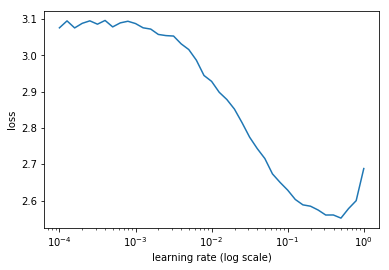

In [19]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 1e-2
learn = ConvLearner.pretrained(f_model, data)
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.883514   1.436956   0.534007  
    1      1.565857   1.222372   0.587929                 
    2      1.39886    1.179132   0.597304                 
    3      1.318134   1.126508   0.620731                 
    4      1.257718   1.075972   0.645997                 
    5      1.182222   1.041503   0.649387                 
    6      1.136547   1.02669    0.654596                 
    7      1.137241   1.044279   0.653288                 
    8      1.170967   1.01894    0.662929                 
    9      1.11313    0.990508   0.674918                 
    10     1.086446   0.957681   0.681168                 
    11     1.047399   0.921352   0.693668                 
    12     1.018226   0.921237   0.692627                 
    13     0.999701   0.920794   0.693668                  
    14     0.992184   0.917397   0.702002                  
    15     1.025285   0.922829   0.686132                  
    16   

[0.82972944, 0.7212826808293661]

In [24]:
learn.unfreeze()
lrs=np.array([1e-4,1e-3,1e-2])
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.346355   0.94808    0.665564  
    1      0.958238   0.650019   0.779126                  
    2      0.757606   0.596289   0.79136                   
    3      0.668834   0.487098   0.819751                  
    4      0.538084   0.447909   0.854657                  
    5      0.443848   0.426586   0.849959                  
    6      0.444539   0.418696   0.852308                  
    7      0.415289   0.410247   0.855964                  
    8      0.368574   0.389075   0.858313                  
    9      0.344486   0.358722   0.870813                  
    10     0.301573   0.355179   0.873938                  
    11     0.28127    0.339845   0.880188                  
    12     0.259258   0.330457   0.880188                  
    13     0.25387    0.322153   0.885396                  
    14     0.251672   0.336188   0.882271                  
    15     0.250275   0.323565   0.883047                

[0.29055828, 0.9070057193438212]

In [25]:
learn.save(f'inc_{sz}')

In [26]:
sz=128
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.636974   0.492129   0.834069  
    1      0.49593    0.380412   0.864542                  
    2      0.430915   0.372063   0.869751                  
    3      0.397035   0.338709   0.883558                  
    4      0.374169   0.322807   0.882516                  
    5      0.350295   0.320103   0.886417                  
    6      0.334151   0.318865   0.880433                  
    7      0.320189   0.311447   0.889032                  
    8      0.327307   0.304296   0.889297                  
    9      0.305863   0.299926   0.89085                   
    10     0.300455   0.290711   0.899449                  
    11     0.288643   0.294921   0.895547                  
    12     0.285344   0.285797   0.897365                  
    13     0.273091   0.286219   0.901532                  
    14     0.276613   0.285114   0.898407                  
    15     0.281076   0.287842   0.893975               

[0.27068332, 0.9067401965459188]

In [27]:
learn.unfreeze()
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)
learn.save(f'inc_{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.281328   0.245782   0.909089  
    1      0.227321   0.27417    0.908313                  
    2      0.183899   0.199404   0.930453                  
    3      0.175898   0.200247   0.92837                   
    4      0.155714   0.175448   0.930453                  
    5      0.134065   0.166168   0.94087                   
    6      0.112347   0.165442   0.941136                  
    7      0.121474   0.159304   0.943219                  
    8      0.117153   0.166049   0.941912                  
    9      0.103248   0.158628   0.943995                  
    10     0.090513   0.158702   0.946078                   
    11     0.080035   0.156234   0.94712                    
    12     0.075583   0.150211   0.948162                   
    13     0.072248   0.151024   0.95337                    
    14     0.065185   0.147647   0.951287                   
    15     0.07126    0.164632   0.946855          

In [28]:
sz=256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.243809   0.238648   0.926021  
    1      0.199194   0.2101     0.935662                  
    2      0.180455   0.207558   0.932802                  
    3      0.167089   0.194257   0.936969                  
    4      0.157413   0.191553   0.934886                  
    5      0.154054   0.187197   0.935927                  
    6      0.140118   0.189524   0.935662                  
    7      0.147288   0.190072   0.932271                  
    8      0.149837   0.183714   0.936703                  
    9      0.144503   0.179788   0.943219                  
    10     0.133071   0.175789   0.942177                  
    11     0.128237   0.176056   0.945302                  
    12     0.124219   0.175807   0.946344                  
    13     0.127381   0.179756   0.945302                  
    14     0.116291   0.176844   0.944261                  
    15     0.121172   0.179632   0.946344               

[0.17395392, 0.9460784316062927]

In [29]:
learn.unfreeze()
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)
learn.save(f'inc_{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.18936    0.161607   0.951552  
    1      0.131867   0.155554   0.951818                  
    2      0.100189   0.133125   0.958844                   
    3      0.0951     0.136744   0.954677                   
    4      0.075191   0.124833   0.958844                   
    5      0.061262   0.12294    0.960927                   
    6      0.054617   0.126915   0.957802                   
    7      0.058781   0.166069   0.948427                   
    8      0.052251   0.124278   0.962234                   
    9      0.049829   0.123234   0.960151                   
    10     0.039214   0.118575   0.967443                   
    11     0.039247   0.122239   0.961193                   
    12     0.030223   0.119925   0.964318                   
    13     0.028595   0.122086   0.963276                   
    14     0.028213   0.116555   0.962234                   
    15     0.031928   0.118894   0.959886  

## Train Model Resnet34 INC

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 56/60 [00:04<00:00, 12.95it/s, loss=23.1]


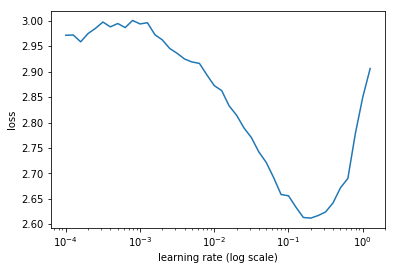

In [11]:
f_model = resnet34
sz=64
data = get_data(sz)
data = data.resize(int(sz*1.3), 'tmp')
learn = ConvLearner.pretrained(f_model, data)

lrf=learn.lr_find()
learn.sched.plot()

In [12]:
lr = 3e-2
learn = ConvLearner.pretrained(f_model, data)
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

learn.unfreeze()
lrs=np.array([1e-4,1e-3,1e-2])
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

learn.save(f'inc34_{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.948075   1.455536   0.522529  
    1      1.720777   1.370533   0.54185                  
    2      1.586368   1.222802   0.593913                 
    3      1.58666    1.244749   0.578799                 
    4      1.49893    1.22556    0.575184                 
    5      1.403033   1.10584    0.636887                 
    6      1.334833   1.091418   0.63558                  
    7      1.388456   1.149391   0.613991                 
    8      1.382739   1.133705   0.610866                 
    9      1.322953   1.094411   0.618954                 
    10     1.286245   1.066782   0.646038                 
    11     1.259735   1.050244   0.640033                 
    12     1.205101   1.029573   0.657761                 
    13     1.177035   1.01676    0.665829                 
    14     1.180336   1.017307   0.660355                 
    15     1.204146   1.082483   0.625715                 
    16     1

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.65707    1.262261   0.582721  
    1      1.246035   0.851495   0.708803                 
    2      1.048349   0.810046   0.718403                 
    3      0.921581   0.669249   0.765543                  
    4      0.786957   0.610982   0.786663                  
    5      0.701499   0.58463    0.798652                  
    6      0.639074   0.575059   0.795527                  
    7      0.639337   0.530622   0.816891                  
    8      0.594492   0.510548   0.827288                  
    9      0.522398   0.455143   0.848917                  
    10     0.473376   0.427273   0.848407                  
    11     0.444832   0.420711   0.846058                  
    12     0.439222   0.418676   0.846834                  
    13     0.417806   0.410868   0.849449                  
    14     0.405394   0.421497   0.842157                  
    15     0.414637   0.413497   0.855699                  

In [13]:
sz=128
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)
learn.save(f'inc34_{sz}')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.000661   0.743613   0.742913  
    1      0.818345   0.587361   0.802288                  
    2      0.718008   0.572645   0.796569                  
    3      0.674167   0.535059   0.812439                  
    4      0.631498   0.505555   0.823917                  
    5      0.607857   0.489361   0.827042                  
    6      0.584138   0.486633   0.831209                  
    7      0.588586   0.492978   0.823141                  
    8      0.589062   0.464773   0.830944                  
    9      0.570843   0.464065   0.833027                  
    10     0.555301   0.451354   0.840319                  
    11     0.541392   0.439117   0.839277                  
    12     0.523013   0.429779   0.844751                  
    13     0.513608   0.426893   0.848917                  
    14     0.496433   0.42704    0.846834                  
    15     0.516895   0.453126   0.83797                 

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.395173   0.317485   0.889808  
    1      0.331337   0.253928   0.908824                  
    2      0.287838   0.237391   0.914032                  
    3      0.270739   0.225879   0.917422                  
    4      0.239775   0.210338   0.923427                  
    5      0.211685   0.203491   0.930719                  
    6      0.203346   0.202098   0.921855                  
    7      0.209811   0.199518   0.925245                  
    8      0.195488   0.186493   0.936969                  
    9      0.18406    0.182171   0.939052                  
    10     0.174013   0.177807   0.934355                  
    11     0.16127    0.172372   0.939828                  
    12     0.143852   0.173741   0.937745                  
    13     0.137706   0.172344   0.933313                  
    14     0.146127   0.174744   0.94087                   
    15     0.150831   0.168576   0.936703               

In [14]:
sz=256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)
learn.save(f'inc34_{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.375472   0.324839   0.894751  
    1      0.323213   0.291109   0.911417                  
    2      0.300862   0.281159   0.907251                  
    3      0.292069   0.25861    0.91924                   
    4      0.282045   0.255391   0.917933                  
    5      0.252686   0.251421   0.923917                  
    6      0.242859   0.253509   0.923407                  
    7      0.246344   0.249734   0.926797                  
    8      0.247663   0.241997   0.926797                  
    9      0.240309   0.239416   0.925756                  
    10     0.230172   0.239328   0.927839                  
    11     0.205765   0.234717   0.930188                  
    12     0.218517   0.232809   0.930964                  
    13     0.207362   0.230569   0.932271                  
    14     0.209921   0.231572   0.932271                  
    15     0.212888   0.23359    0.928881               

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.22237    0.183843   0.934886  
    1      0.17738    0.150846   0.948672                  
    2      0.149039   0.14605    0.94998                   
    3      0.131433   0.129901   0.953105                  
    4      0.122923   0.145932   0.941912                  
    5      0.106987   0.143673   0.947386                  
    6      0.100519   0.138338   0.950245                   
    7      0.104457   0.141621   0.950776                   
    8      0.096079   0.144309   0.945568                   
    9      0.092618   0.117494   0.961193                   
    10     0.081777   0.117873   0.961193                   
    11     0.069413   0.120078   0.959109                   
    12     0.070669   0.115271   0.960151                   
    13     0.065998   0.116377   0.961193                   
    14     0.059799   0.11604    0.960151                   
    15     0.062086   0.116636   0.963276      

## Submission

In [11]:
sz=256
learn.set_data(get_data(sz))
learn.load(f'inc_{sz}')

log_preds, y = learn.TTA()
accuracy_np(np.mean(np.exp(log_preds),0), y)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

0.9619852164730729

In [12]:
log_preds, y = learn.TTA(is_test=True)
preds_avg = np.mean(log_preds, axis=0)
preds = np.argmax(preds_avg, axis=1)
probs = np.exp(preds_avg)

In [13]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0,'file',[y.split('/')[-1] for y in data.test_ds.fnames ] )
df = df.set_index('file')
df.head()

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
file,,,,,,,,,,,,
f1f7c833f.png,4.968228e-12,1.291115e-07,1.268847e-07,1.940171e-05,1.348892e-12,4.542946e-09,6.675393e-11,4.973597e-11,1.587579e-06,9.999208e-01,1.717427e-06,1.839697e-10
cd5f0db1c.png,2.722000e-09,6.726206e-08,5.284780e-08,1.841716e-07,1.538128e-09,1.513250e-06,4.478806e-09,6.880774e-09,3.609224e-08,2.649914e-06,9.999935e-01,1.391659e-10
2d9c798f9.png,5.521365e-09,1.720774e-08,1.855834e-07,1.031189e-05,6.973458e-09,3.370371e-06,1.765361e-08,5.172963e-08,3.334156e-08,2.091346e-06,9.999813e-01,5.536041e-10
f0ffa00bd.png,5.294170e-05,4.865747e-07,2.649796e-05,3.210056e-04,5.573082e-05,1.548999e-05,3.724511e-06,7.124696e-05,2.965616e-04,4.027427e-07,2.428351e-08,9.630401e-01
88ac6df54.png,6.249447e-02,2.028363e-09,1.236365e-07,6.859523e-08,3.500840e-06,7.443944e-07,8.205314e-01,1.794797e-08,2.451088e-06,7.631213e-09,3.604017e-08,1.380684e-07


In [14]:
df2 = df.idxmax(axis=1).to_frame()
df2.columns = ['species']
df2.to_csv('plant-sub1.gz', compression='gzip', index=True, header=True)
FileLink('plant-sub1.gz')

/home/luke/fastai-p1-luke/plant-sub1.gz

### End